In [1]:
pip install sqlalchemy psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sqlalchemy import create_engine

In [3]:
db_host='localhost'
db_port=5432
db_name='covid_19'
db_user='postgres'
db_password='bharu245'

In [4]:
db_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

In [5]:
engine = create_engine(db_string)
connection = engine.connect()

In [6]:
import requests
import json
import pandas as pd
response = requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/json/')
print(response.status_code)
json_data = response.json()

df_flat=pd.json_normalize(json_data,'records')

df=pd.DataFrame(df_flat)


200


In [7]:
#drop null values
df.dropna(axis = 1)
print(df)

          dateRep day month  year  cases  deaths countriesAndTerritories  \
0      14/12/2020  14    12  2020    746       6             Afghanistan   
1      13/12/2020  13    12  2020    298       9             Afghanistan   
2      12/12/2020  12    12  2020    113      11             Afghanistan   
3      11/12/2020  11    12  2020     63      10             Afghanistan   
4      10/12/2020  10    12  2020    202      16             Afghanistan   
...           ...  ..   ...   ...    ...     ...                     ...   
61895  25/03/2020  25    03  2020      0       0                Zimbabwe   
61896  24/03/2020  24    03  2020      0       1                Zimbabwe   
61897  23/03/2020  23    03  2020      0       0                Zimbabwe   
61898  22/03/2020  22    03  2020      1       0                Zimbabwe   
61899  21/03/2020  21    03  2020      1       0                Zimbabwe   

      geoId countryterritoryCode  popData2019 continentExp  \
0        AF              

In [8]:
df.describe()

,cases,deaths,popData2019
count,61900.000000,61900.000000,6.177700e+04
mean,1155.147237,26.055460,4.098770e+07
std,6779.224479,131.227055,1.531294e+08
min,-8261.000000,-1918.000000,8.150000e+02
25%,0.000000,0.000000,1.293120e+06
50%,15.000000,0.000000,7.169456e+06
75%,273.000000,4.000000,2.851583e+07
max,234633.000000,4928.000000,1.433784e+09


In [9]:
#load the data to tables
df.to_sql('covid_data', connection, if_exists='replace', index=False)

900

In [10]:
subset_df = df.loc[:, ['countriesAndTerritories', 'cases']]
print(subset_df)

      countriesAndTerritories  cases
0                 Afghanistan    746
1                 Afghanistan    298
2                 Afghanistan    113
3                 Afghanistan     63
4                 Afghanistan    202
...                       ...    ...
61895                Zimbabwe      0
61896                Zimbabwe      0
61897                Zimbabwe      0
61898                Zimbabwe      1
61899                Zimbabwe      1

[61900 rows x 2 columns]


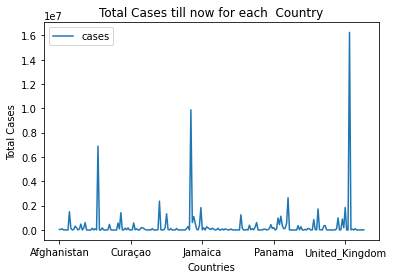

In [11]:
#total covid cases tilll now for each country
import pandas as pd
import matplotlib.pyplot as plt


group_cases = subset_df.groupby('countriesAndTerritories').agg({'cases': 'sum'})

group_cases.plot(kind='line')
plt.xlabel('Countries')
plt.ylabel('Total Cases')
plt.title('Total Cases till now for each  Country')
plt.show()

In [12]:
group_cases.to_sql('total_cases_for_country',connection, if_exists='replace', index=False)

214

In [13]:
sorted_df = df.sort_values(by='deaths', ascending=False)

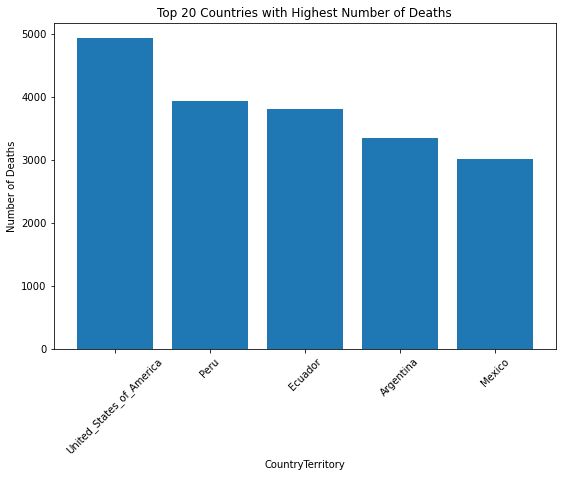

In [14]:
# a bar plot showing the top 20 countries with the highest number of deaths. 
plt.figure(figsize=(9, 6))
plt.bar(sorted_df['countriesAndTerritories'].head(20), sorted_df['deaths'].head(20))
plt.xlabel('CountryTerritory')
plt.ylabel('Number of Deaths')
plt.title('Top 20 Countries with Highest Number of Deaths')
plt.xticks(rotation=45)
plt.show()


In [15]:
sub_df=df.loc[:, ['month', 'cases','deaths']]

In [ ]:

# Calculate the number of deaths registered for every case
df['deaths_rate_by_case'] = (df['deaths'] / df['cases'])*100

df['deaths_rate_population'] = (df['deaths'] / df['popData2019'])*100


In [ ]:
df_d=df.loc[:, ['countriesAndTerritories', 'cases','deaths','deaths_rate_by_case','deaths_rate_population']]
print(df_d)

df_d.to_sql('report_death', connection, if_exists='replace', index=False)

In [31]:
covid_cases = df.groupby('month')['cases'].mean().reset_index()
sorted_cases = covid_cases.rename(columns={'cases': 'avg_cases'})


deaths = df.groupby('month')['deaths'].mean().reset_index()
sorted_deaths = deaths.rename(columns={'deaths': 'avg_deaths'})


merged_data = pd.merge(sorted_cases, sorted_deaths, on='month', how='outer')


merged_data.sort_values(by='month', inplace=True)

merged_data.to_sql('monthly_covid_data', connection, if_exists='replace', index=False)

12

Text(0.5, 1.0, 'average deaths for avg covid cases')

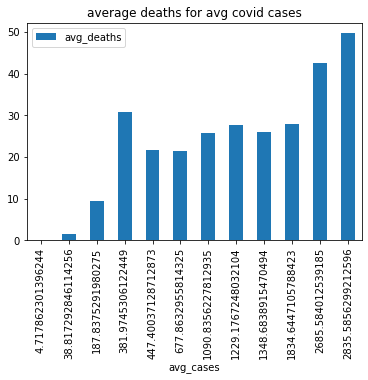

In [34]:
merged_data.plot(x='avg_cases',y='avg_deaths',kind='bar')
plt.title('average deaths for avg covid cases')

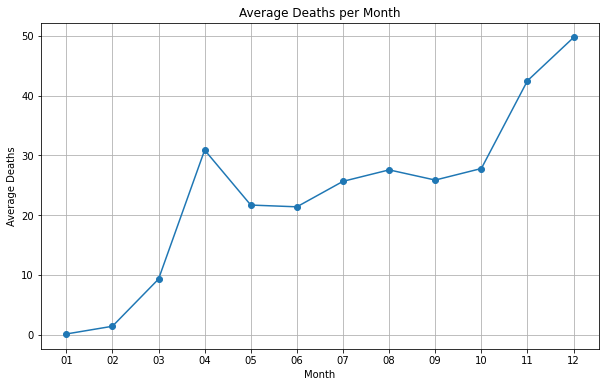

In [35]:

deaths = df.groupby('month')['deaths'].mean().reset_index()

sorted_deaths = deaths.sort_values(by='month', ascending=True)

plt.figure(figsize=(10, 6))
plt.plot(sorted_deaths['month'], sorted_deaths['deaths'], marker='o')
plt.xlabel('Month')
plt.ylabel('Average Deaths')
plt.title('Average Deaths per Month')
plt.grid(True)
plt.show()
